<a href="https://colab.research.google.com/github/calebskim/Deep-Learning-Assignment-4/blob/main/DeepLearningAssignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install ucimlrepo

import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Add
import matplotlib.pyplot as plt

In [12]:
# fetch dataset
covertype = fetch_ucirepo(id=31)

# data (as pandas dataframes)
X = covertype.data.features
y = covertype.data.targets

# metadata
print(covertype.metadata)

# variable information
print(covertype.variables)

{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell) was determined from

In [13]:
# Let's see what y looks like first
print(y.value_counts())  # check class distribution
y_binary = (y.iloc[:, 0] == 1).astype(int)

# normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=42
)

Cover_Type
2             283301
1             211840
3              35754
7              20510
6              17367
5               9493
4               2747
Name: count, dtype: int64


In [14]:
# preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=42
)

X_batch = X_train[:128]
y_batch = y_train[:128]

In [15]:
# building the model
inputs = Input(shape=(X.shape[1],), name="Input")
x = Dense(32, activation='relu', name="Dense_1")(inputs)

# residual Block
res_input = x
res_x = Dense(32, activation='relu', name="Res_Dense_1")(res_input)
res_x = Dense(32, activation='relu', name="Res_Dense_2")(res_x)
res_out = Add(name="Residual_Add")([res_input, res_x])

skip_proj = Dense(16, activation='relu', name="Skip_Proj")(inputs)

# continuing after residual
x = Dense(16, activation='relu', name="Post_Res")(res_out)
x = Add(name="Skip_Add")([x, skip_proj])

# final output layer
output = Dense(1, activation='sigmoid', name="Output")(x)

# defining the model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)        │ (None, 54)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_1 (Dense)           │ (None, 32)             │          1,760 │ Input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Res_Dense_1 (Dense)       │ (None, 32)             │          1,056 │ Dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Res_Dense_2 (Dense)       │ (None, 32)             │          1,056 │ Res_Dense_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Residual_Add (Add)        │ (None, 32)             │              0 │ Dense_1[0][0],         │
│                           │                        │                │ Res_Dense_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Post_Res (Dense)          │ (None, 16)             │            528 │ Residual_Add[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Skip_Proj (Dense)         │ (None, 16)             │            880 │ Input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Skip_Add (Add)            │ (None, 16)             │              0 │ Post_Res[0][0],        │
│                           │                        │                │ Skip_Proj[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output (Dense)            │ (None, 1)              │             17 │ Skip_Add[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,297 (20.69 KB)

 Trainable params: 5,297 (20.69 KB)

 Non-trainable params: 0 (0.00 B)

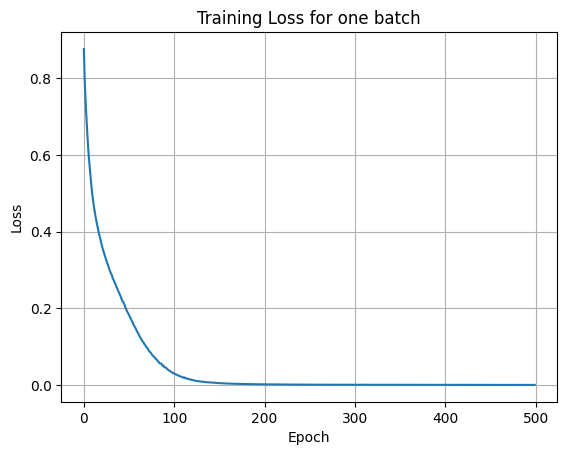

In [16]:
# training the model with epochs = 500
history = model.fit(X_batch, y_batch, epochs=500, verbose=0)

# plotting the training loss
plt.plot(history.history['loss'])
plt.title("Training Loss for one batch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [17]:
# evaluating on validation
train_loss = model.evaluate(X_batch, y_batch, verbose=0)[0]
val_loss = model.evaluate(X_val, y_val, verbose=0)[0]

# printing results
print(f"\nNumber of parameters: {model.count_params()}")
print(f"Final training loss (on 1 batch): {train_loss:.4f}")
print(f"Final validation loss: {val_loss:.4f}")

# checking accuracy too
train_acc = model.evaluate(X_batch, y_batch, verbose=0)[1]
val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print(f"Train accuracy: {train_acc:.4f}")
print(f"Val accuracy: {val_acc:.4f}")


Number of parameters: 5297
Final training loss (on 1 batch): 0.0001
Final validation loss: 3.8207
Train accuracy: 1.0000
Val accuracy: 0.6474


In [18]:
# saving architecture for visualization
model.save("model_overfit.h5")